In [1]:
# Re-run after transient reset.
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from sklearn.linear_model import LogisticRegression 

In [2]:
class ExponentialFamily:
    def __init__(self, eta, T, h, support):
        self.eta = np.asarray(eta)
        self.T = T
        self.h = h
        self.support = support
        
    def log_partition(self, grid):
        vals = []
        for x in grid:
            if self.support(x):
                vals.append(np.log(self.h(x)) + np.dot(self.eta, self.T(x)))
        return logsumexp(vals)
    
    def log_prob(self, x, A=None):
        if not self.support(x):
            return -np.inf
        if A is None:
            raise ValueError("Need log-partition A(eta)")
        return np.log(self.h(x)) + np.dot(self.eta, self.T(x)) - A


λ1=2.0: empirical mean=0.4970, theoretical mean=0.5000
λ2=0.5: empirical mean=2.0233, theoretical mean=2.0000


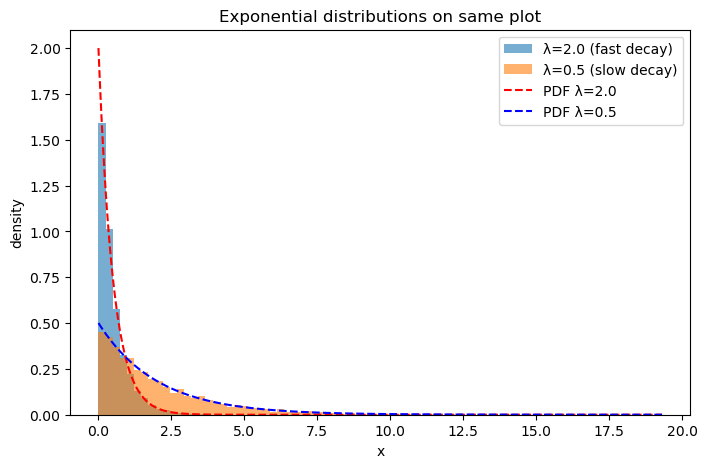

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
lam1, lam2 = 2.0, 0.5
n = 5000
rng = np.random.default_rng(7)
x1 = rng.exponential(scale=1/lam1, size=n)
x2 = rng.exponential(scale=1/lam2, size=n)

mean1, mean2 = x1.mean(), x2.mean()
theory1, theory2 = 1/lam1, 1/lam2

print(f"λ1={lam1}: empirical mean={mean1:.4f}, theoretical mean={theory1:.4f}")
print(f"λ2={lam2}: empirical mean={mean2:.4f}, theoretical mean={theory2:.4f}")

# Plot both histograms on the same figure
bins = np.linspace(0, max(x2.max(), x1.max()), 80)

plt.figure(figsize=(8,5))
plt.hist(x1, bins=bins, density=True, alpha=0.6, label=f"λ={lam1} (fast decay)")
plt.hist(x2, bins=bins, density=True, alpha=0.6, label=f"λ={lam2} (slow decay)")

# Overlay theoretical pdfs
xgrid = np.linspace(0, bins.max(), 400)
plt.plot(xgrid, lam1*np.exp(-lam1*xgrid), 'r--', label=f"PDF λ={lam1}")
plt.plot(xgrid, lam2*np.exp(-lam2*xgrid), 'b--', label=f"PDF λ={lam2}")

plt.title("Exponential distributions on same plot")
plt.xlabel("x"); plt.ylabel("density")
plt.legend()
plt.show()


/home/yuen_chen/anaconda3/envs/goat/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Decision boundary (source-trained): x* = -0.0048
Source accuracy: 0.997
Target accuracy: 0.510


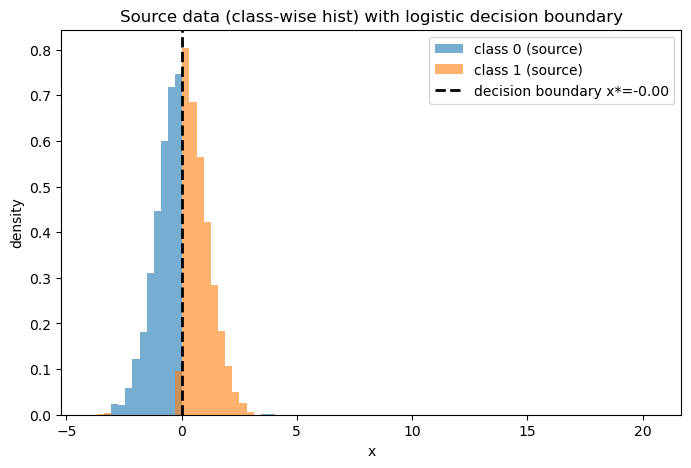

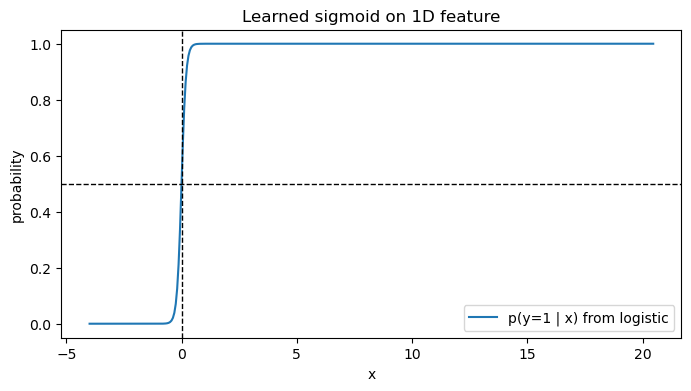

In [4]:
# Plot samples interpolated from three geodesics (OT, natural-η, Fisher–Rao) side by side (one figure per t).
# Setting: 1D Gaussians with different mean/variance.
import numpy as np
import matplotlib.pyplot as plt


# === Helper: OT (W2) geodesic for 1D Gaussians ===
def T_gauss(x, mu0, sigma0, mu1, sigma1):
    return mu1 + (sigma1 / sigma0) * (x - mu0)

def ot_geodesic_samples(rng, t, mu0, sigma0, mu1, sigma1, n):
    # Build from source samples using the Monge map
    X = rng.normal(mu0, sigma0, size=n)
    Z = (1 - t) * X + t * T_gauss(X, mu0, sigma0, mu1, sigma1)
    return Z

# === Helper: natural-parameter (e-geodesic) interpolation ===
# η1=μ/σ^2, η2=-1/(2σ^2)
def to_natural(mu, sigma2):
    return np.array([mu / sigma2, -0.5 / sigma2])

def from_natural(eta):
    eta1, eta2 = eta
    sigma2 = -1.0 / (2.0 * eta2)
    mu = eta1 * sigma2
    return mu, sigma2

def eta_interpolated_params(t, eta_src, eta_tgt):
    eta_t = (1 - t) * eta_src + t * eta_tgt
    mu_t, sigma2_t = from_natural(eta_t)
    return float(mu_t), float(np.sqrt(sigma2_t))

def eta_geodesic_samples(rng, t, eta_src, eta_tgt, n):
    mu_t, sd_t = eta_interpolated_params(t, eta_src, eta_tgt)
    return rng.normal(mu_t, sd_t, size=n)

# === Helper: Fisher–Rao geodesic for 1D Gaussians ===
# Map to Poincaré half-plane (u=mu/sqrt(2), v=sigma) and use circle/vertical geodesic.
def fisher_rao_geodesic_params(mu0, sigma0, mu1, sigma1, t):
    u0, v0 = mu0/np.sqrt(2.0), sigma0
    u1, v1 = mu1/np.sqrt(2.0), sigma1
    if np.isclose(u0, u1):
        u_t = u0
        v_t = v0**(1-t) * v1**t
    else:
        a = (u0*u0 + v0*v0 - u1*u1 - v1*v1) / (2*(u0 - u1))
        R = np.sqrt((u0 - a)**2 + v0*v0)
        th0 = np.arctan2(v0, u0 - a)
        th1 = np.arctan2(v1, u1 - a)
        th = (1 - t) * th0 + t * th1
        u_t = a + R * np.cos(th)
        v_t = R * np.sin(th)
    mu_t = np.sqrt(2.0) * u_t
    sigma_t = v_t
    return float(mu_t), float(sigma_t)

def fisher_rao_geodesic_samples(rng, t, mu0, sigma0, mu1, sigma1, n):
    mu_t, sd_t = fisher_rao_geodesic_params(mu0, sigma0, mu1, sigma1, t)
    return rng.normal(mu_t, sd_t, size=n)


# ----- OT geodesic (1D Gaussian) -----
def eta_true_OT(t):
    mu_t = (1 - t) * mu0 + t * mu1
    sigma_t = (1 - t) * sigma0 + t * sigma1
    return to_natural(mu_t, sigma_t**2)

# ----- Natural-parameter (η) interpolation -----
def eta_interp_eta(t):
    return (1 - t) * eta_src + t * eta_tgt

# ----- Fisher–Rao geodesic (univariate) -----
def fisher_rao_geodesic_univariate(mu0, sigma0, mu1, sigma1, ts):
    # Map to Poincaré half-plane
    u0, v0 = mu0/np.sqrt(2.0), sigma0
    u1, v1 = mu1/np.sqrt(2.0), sigma1
    us, vs = [], []
    if np.isclose(u0, u1):
        for t in ts:
            us.append(u0)
            vs.append(v0**(1-t) * v1**t)  # vertical geodesic (geometric interpolation in v)
    else:
        a = (u0*u0 + v0*v0 - u1*u1 - v1*v1) / (2*(u0 - u1))
        R = np.sqrt((u0 - a)**2 + v0*v0)
        th0 = np.arctan2(v0, u0 - a)
        th1 = np.arctan2(v1, u1 - a)
        for t in ts:
            th = (1-t)*th0 + t*th1
            us.append(a + R*np.cos(th))
            vs.append(R*np.sin(th))
    mus = np.sqrt(2.0)*np.array(us)
    sigmas = np.array(vs)
    return mus, sigmas

# ----- Barycentric OT via Sinkhorn -----
def sinkhorn(a, b, C, eps=0.1, iters=400):
    K = np.exp(-C / eps)
    u = np.ones_like(a)
    v = np.ones_like(b)
    for _ in range(iters):
        u = a / (K @ v + 1e-16)
        v = b / (K.T @ u + 1e-16)
    P = (u[:, None] * K) * v[None, :]
    return P

def eta_from_bary_samples(t, X, Y_bary):
    Z = (1 - t) * X + t * Y_bary
    mu_hat = float(Z.mean())
    sigma2_hat = float(((Z - mu_hat)**2).mean())  # MLE variance
    return to_natural(mu_hat, sigma2_hat)

def eta_from_samples(t, X):
    mu_hat = float(X.mean())
    sigma2_hat = float(((X - mu_hat)**2).mean())  # MLE variance
    return to_natural(mu_hat, sigma2_hat)

def eta_from_samples_general(samples, T, gradA, hessA, eta_init, weights=None, 
                             max_iter=100, tol=1e-10):
    """
    Estimate natural parameters eta for a general exponential family:
        p(x|eta) = h(x) * exp( eta^T T(x) - A(eta) ).
    Uses the MLE condition: E_eta[T(X)] = empirical mean of T(X),
    solved by Newton on gradA(eta) = theta_hat.

    Args
    ----
    samples : array-like, shape (n, ...)  # any shape your T accepts
    T       : callable, T(x) -> array-like shape (d,)
    gradA   : callable, gradA(eta) -> array-like shape (d,)
    hessA   : callable, hessA(eta) -> array-like shape (d,d)
    eta_init: array-like, shape (d,)  # starting guess
    weights : optional nonnegative weights, shape (n,)
    max_iter: int
    tol     : float  # stop when ||gradA(eta) - theta_hat||_2 <= tol

    Returns
    -------
    eta_hat : np.ndarray, shape (d,)
    theta_hat : np.ndarray, shape (d,)   # empirical expectation parameters
    """
    samples = np.asarray(samples)
    # empirical sufficient stats
    if weights is None:
        Ts = np.array([T(x) for x in samples])
        theta_hat = Ts.mean(axis=0)
    else:
        w = np.asarray(weights).reshape(-1, 1)
        Ts = np.array([T(x) for x in samples])
        theta_hat = (w * Ts).sum(axis=0) / (w.sum() + 1e-16)

    eta = np.asarray(eta_init, dtype=float)
    for _ in range(max_iter):
        g = gradA(eta) - theta_hat           # f(eta) we want to drive to 0
        if np.linalg.norm(g) <= tol:
            break
        H = hessA(eta)                       # Hessian of A = Fisher information
        step = np.linalg.solve(H, g)         # Newton step
        eta = eta - step
    return eta, theta_hat



# --- Endpoints ---
mu0, sigma0 = 0.0, 1.0     # source N(0,1)
mu1, sigma1 = 10.0, 3     # target N(2,0.25)
n = 5000                   # samples per interpolated distribution
eta_src = to_natural(mu0, sigma0**2)
eta_tgt = to_natural(mu1, sigma1**2)

labeling_function = lambda x: (np.sin(x) > 0).astype(int)

X_0 = rng.normal(mu0, sigma0, size=n).reshape(-1, 1)
Y_0 = labeling_function(X_0)
X_T = rng.normal(mu1, sigma1, size=n).reshape(-1, 1)
Y_T = labeling_function(X_T)
clf = LogisticRegression(penalty='l2').fit(X_0, Y_0)

# plot the data as bar chart and decision boundary
# Decision boundary for 1D logistic: w0 + w1*x = 0  ->  x* = -intercept_/coef_
w = clf.coef_.ravel()[0]
b = clf.intercept_.ravel()[0]
x_star = -b / w

print(f"Decision boundary (source-trained): x* = {x_star:.4f}")
print(f"Source accuracy: {clf.score(X_0, Y_0):.3f}")
print(f"Target accuracy: {clf.score(X_T, Y_T):.3f}")

# --- Plot 1: class-wise histograms for the SOURCE + decision boundary ---
bins = np.linspace(min(X_0.min(), X_T.min())-0.5, max(X_0.max(), X_T.max())+0.5, 80)

plt.figure(figsize=(8,5))
plt.hist(X_0[Y_0.ravel()==0].ravel(), bins=bins, alpha=0.6, density=True, label="class 0 (source)")
plt.hist(X_0[Y_0.ravel()==1].ravel(), bins=bins, alpha=0.6, density=True, label="class 1 (source)")
plt.axvline(x_star, color='k', linestyle='--', linewidth=2, label=f"decision boundary x*={x_star:.2f}")
plt.title("Source data (class-wise hist) with logistic decision boundary")
plt.xlabel("x"); plt.ylabel("density"); plt.legend()
plt.show()

# --- Plot 2: model probability curve p(y=1|x) ---
xgrid = np.linspace(bins.min(), bins.max(), 400).reshape(-1, 1)
p1 = clf.predict_proba(xgrid)[:,1]

plt.figure(figsize=(8,4))
plt.plot(xgrid, p1, label="p(y=1 | x) from logistic")
plt.axhline(0.5, color='k', linestyle='--', linewidth=1)
plt.axvline(x_star, color='k', linestyle='--', linewidth=1)
plt.title("Learned sigmoid on 1D feature")
plt.xlabel("x"); plt.ylabel("probability"); plt.legend()
plt.ylim(-0.05, 1.05)
plt.show()



In [ ]:
# =========================================
# Expansion & Self-Training on 1D Gaussian
# (only first covariance eigenvalue λ varies)
# =========================================

# ----- Imports
import math
import heapq
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, log_loss
import copy

# =========================================
# Section 1: Metric helpers
# =========================================

METRICS = ("FR", "W2", "eta")

def metric_distance(metric: str, a: float, b: float) -> float:
    if metric == "FR":
        return abs(math.log(b / a))
    if metric == "W2":
        return abs(math.sqrt(b) - math.sqrt(a))
    if metric == "eta":
        return abs(1.0 / b - 1.0 / a)
    raise ValueError(f"Unknown metric: {metric}")

def metric_chart(metric: str, lam: np.ndarray) -> np.ndarray:
    if metric == "FR":
        return np.log(lam)
    if metric == "W2":
        return np.sqrt(lam)
    if metric == "eta":
        return 1.0 / lam
    raise ValueError(f"Unknown metric: {metric}")

def metric_inv_chart(metric: str, phi: np.ndarray) -> np.ndarray:
    if metric == "FR":
        return np.exp(phi)
    if metric == "W2":
        return phi**2
    if metric == "eta":
        return 1.0 / phi
    raise ValueError(f"Unknown metric: {metric}")

def geodesic_closed_form(metric: str, t: float, a: float, b: float) -> float:
    if metric == "FR":
        return a ** (1 - t) * b ** t
    if metric == "W2":
        return ((1 - t) * math.sqrt(a) + t * math.sqrt(b)) ** 2
    if metric == "eta":
        return 1.0 / ((1 - t) / a + t / b)
    raise ValueError(f"Unknown metric: {metric}")

def geodesic_length_closed(metric: str, a: float, b: float) -> float:
    return metric_distance(metric, a, b)

# =========================================
# Section 2: A* on λ-grid (expansion)
# =========================================

def build_lambda_grid(a: float, b: float, n: int) -> np.ndarray:
    lo, hi = (a, b) if a <= b else (b, a)
    return np.linspace(lo, hi, n)

def build_grid_mu_lambda(mu0, mu1, lam0, lam1, n_mu, n_lam):
    mus  = np.linspace(min(mu0, mu1), max(mu0, mu1), n_mu)
    lams = np.linspace(min(lam0, lam1), max(lam0, lam1), n_lam)
    return mus, lams  # states indexed by (i,j)



def build_adj(N: int, K: int) -> Dict[int, List[int]]:
    adj = {i: [] for i in range(N)}
    for i in range(N):
        for j in range(max(0, i-K), min(N, i+K+1)):
            if j != i:
                adj[i].append(j)
    return adj


def build_adj_2d(n_mu, n_lam, K=1):
    adj = {}
    for i in range(n_mu):
        for j in range(n_lam):
            nbrs = []
            for di in range(-K, K+1):
                for dj in range(-K, K+1):
                    if di == 0 and dj == 0: continue
                    ii, jj = i+di, j+dj
                    if 0 <= ii < n_mu and 0 <= jj < n_lam:
                        nbrs.append((ii, jj))
            adj[(i,j)] = nbrs
    return adj


def a_star_lambda_path(metric: str,
                       lam0: float,
                       lam1: float,
                       grid: np.ndarray,
                       K: int = 2) -> Tuple[np.ndarray, np.ndarray, float]:
    """A* in λ-space using given metric; returns (λ_path, t_arc, total_length)."""
    N = len(grid)
    s = int(np.argmin(np.abs(grid - lam0))) #start node
    g = int(np.argmin(np.abs(grid - lam1))) #goal node
    adj = build_adj(N, K) # builds the neighbor list of N nodes and radius K

    g_cost = np.full(N, np.inf)
    parent = np.full(N, -1, dtype=int)
    g_cost[s] = 0.0 # current best-known cost of the shortest path from the start node s to itself is 0

    def h(i: int) -> float:
        return metric_distance(metric, grid[i], grid[g])  # admissible

    # Priority queue for A* search, storing (f-value, vertex) pairs
    # f-value = g_cost (path length from start) + h (heuristic to goal)
    pq = [(g_cost[s] + h(s), s)]  # cost of the shortest path from the start node s to itself + heuristic to goal
    closed = np.zeros(N, dtype=bool)  # Track visited vertices

    while pq:
        f_u, u = heapq.heappop(pq)
        if closed[u]:
            continue

        closed[u] = True
        # if u is the goal node, break
        if u == g:
            break
        # for each neighbor v of u
        for v in adj[u]:
            w = metric_distance(metric, grid[u], grid[v])
            tentative = g_cost[u] + w # cost to reach u from beginning + cost to reach v from u
            if tentative < g_cost[v]:
                g_cost[v] = tentative
                parent[v] = u
                heapq.heappush(pq, (tentative + h(v), v))

    # reconstruct path
    path_idx = []
    cur = g
    assert parent[cur] != -1 or cur == s, "A*: path not found"
    while cur != -1:
        path_idx.append(cur)
        cur = parent[cur]
    path_idx.reverse()
    lam_path = grid[path_idx]

    # arc-length parameter t ∈ [0,1]
    seg = [0.0]
    for i in range(1, len(lam_path)):
        seg.append(seg[-1] + metric_distance(metric, lam_path[i-1], lam_path[i]))
    seg = np.array(seg)
    total = float(seg[-1]) if len(seg) else 1.0
    t_arc = seg / total if total > 0 else seg
    return lam_path, t_arc, total

def a_star_mu_lambda_path(
    metric: str,
    mu0: float, lam0: float,        # start
    mu1: float, lam1: float,        # goal
    mus: np.ndarray,                # 1D grid for mu (length n_mu)
    lams: np.ndarray,               # 1D grid for lambda (length n_lam; values > 0)
    K: int = 1                      # neighbor span on each axis (1 => 4/8-neighborhood)
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    A* in (mu, lambda)-space on a 2D grid using the chosen metric.
    Returns (mu_path, lam_path, t_arc, total_length).

    metric in {"FR", "W2", "eta"}:
      - FR (1D Normal): local length^2 = (dmu^2)/lam_bar + 0.5*(dloglam^2),   lam_bar = sqrt(lam*lam')
      - W2 (1D Normal): length = sqrt( (mu'-mu)^2 + (sqrt(lam')-sqrt(lam))^2 )
      - eta (natural coords): theta=(mu/lam, -1/(2*lam)), Euclidean in theta
    """
    import math
    from math import sqrt, log, hypot

    n_mu, n_lam = len(mus), len(lams)

    # --- index helpers
    def snap_idx(arr, x):
        return int(np.argmin(np.abs(arr - x)))

    def neighbors(i, j):
        for di in range(-K, K+1):
            for dj in range(-K, K+1):
                if di == 0 and dj == 0:
                    continue
                ii, jj = i + di, j + dj
                if 0 <= ii < n_mu and 0 <= jj < n_lam:
                    yield ii, jj

    # --- edge costs
    def cost_FR(mu, lam, mu2, lam2):
        # guard against tiny/zero lambdas
        lam = max(lam, 1e-300); lam2 = max(lam2, 1e-300)
        lam_bar = sqrt(lam * lam2)  # geometric mean
        dmu = mu2 - mu
        dloglam = log(lam2) - log(lam)
        return sqrt((dmu * dmu) / lam_bar + 0.5 * (dloglam * dloglam))

    def cost_W2(mu, lam, mu2, lam2):
        return hypot(mu2 - mu, sqrt(max(lam2, 0.0)) - sqrt(max(lam, 0.0)))

    def cost_eta(mu, lam, mu2, lam2):
        # Euclidean in natural parameters theta = (mu/lam, -1/(2*lam))
        lam = max(lam, 1e-300); lam2 = max(lam2, 1e-300)
        th1, th2 = (mu / lam), (-0.5 / lam)
        th1b, th2b = (mu2 / lam2), (-0.5 / lam2)
        return hypot(th1b - th1, th2b - th2)

    if metric == "FR":
        edge_cost = cost_FR
    elif metric == "W2":
        edge_cost = cost_W2
    elif metric == "eta":
        edge_cost = cost_eta
    else:
        raise ValueError(f"Unknown metric: {metric}")

    # Heuristic: same metric to the goal (admissible by triangle inequality)
    def h(mu, lam):
        return edge_cost(mu, lam, mu_goal, lam_goal)

    # --- snap start/goal to grid
    si, sj = snap_idx(mus, mu0), snap_idx(lams, lam0)
    gi, gj = snap_idx(mus, mu1), snap_idx(lams, lam1)
    mu_goal, lam_goal = mus[gi], lams[gj]

    # --- A* tables
    INF = float("inf")
    g_cost = np.full((n_mu, n_lam), INF, dtype=float)
    parent = { (si, sj): None }

    g_cost[si, sj] = 0.0
    start_f = g_cost[si, sj] + h(mus[si], lams[sj])

    # priority queue of (f, i, j)
    pq: List[Tuple[float, int, int]] = [(start_f, si, sj)]
    closed = np.zeros((n_mu, n_lam), dtype=bool)

    while pq:
        f_u, ui, uj = heapq.heappop(pq)
        if closed[ui, uj]:
            continue
        closed[ui, uj] = True
        if (ui, uj) == (gi, gj):
            break

        mu_u, lam_u = mus[ui], lams[uj]
        for vi, vj in neighbors(ui, uj):
            mu_v, lam_v = mus[vi], lams[vj]
            w = edge_cost(mu_u, lam_u, mu_v, lam_v)
            tentative = g_cost[ui, uj] + w
            if tentative < g_cost[vi, vj]:
                g_cost[vi, vj] = tentative
                parent[(vi, vj)] = (ui, uj)
                f_v = tentative + h(mu_v, lam_v)
                heapq.heappush(pq, (f_v, vi, vj))

    # --- reconstruct path
    assert (gi, gj) in parent or (gi, gj) == (si, sj), "A*: path not found"
    idx_path = []
    cur = (gi, gj)
    while cur is not None:
        idx_path.append(cur)
        cur = parent.get(cur, None)
    idx_path.reverse()

    mu_path = np.array([mus[i] for i, j in idx_path], dtype=float)
    lam_path = np.array([lams[j] for i, j in idx_path], dtype=float)

    # --- arc-length parameterization t_arc in [0,1]
    seg = [0.0]
    for k in range(1, len(idx_path)):
        (i0, j0), (i1, j1) = idx_path[k-1], idx_path[k]
        seg.append(seg[-1] + edge_cost(mus[i0], lams[j0], mus[i1], lams[j1]))
    seg = np.asarray(seg, dtype=float)
    total = float(seg[-1]) if len(seg) else 1.0
    t_arc = seg / total if total > 0 else seg

    return mu_path, lam_path, t_arc, total


# =========================================
# Section 3: Analytic-path vs A* comparisons
# =========================================

def compare_astar_to_true(metric: str,
                          lam0: float = LAM0,
                          lam1: float = LAM1,
                          grid_n: int = GRID_N,
                          neighbor_span: int = NEIGHBOR_SPAN,
                          t_points: int = 401):
    """Plot λ(t): true geodesic vs A* (reparam by arc-length)."""
    grid = build_lambda_grid(lam0, lam1, grid_n)
    lam_path, t_arc, total_len = a_star_lambda_path(metric, lam0, lam1, grid, neighbor_span)

    t_uniform = np.linspace(0, 1, t_points)
    lam_true = np.array([geodesic_closed_form(metric, t, lam0, lam1) for t in t_uniform])

    # Interpolate A* onto uniform t
    f_lam = interp1d(t_arc, lam_path, kind="linear", fill_value="extrapolate", bounds_error=False)
    lam_astar_on_t = f_lam(t_uniform)

    # Charts (where metric is Euclidean)
    phi_true = metric_chart(metric, lam_true)
    phi_astar = metric_chart(metric, lam_astar_on_t)

    # Plots
    plt.figure(figsize=(7,4))
    plt.plot(t_uniform, lam_true, "--", label="True geodesic")
    plt.plot(t_uniform, lam_astar_on_t, label="A* (reparam)")
    plt.xlabel("t"); plt.ylabel("λ(t)"); plt.title(f"{metric}: λ(t) — True vs A*")
    plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(t_uniform, np.abs(phi_true - phi_astar))
    plt.xlabel("t"); plt.ylabel("|φ_A* - φ_true|")
    plt.title(f"{metric}: Error in Euclidean chart φ(λ)")
    plt.show()

    print(f"[{metric}] length — true: {geodesic_length_closed(metric, lam0, lam1):.6f} | A*: {total_len:.6f}")

# =========================================
# Section 4: Gaussian generator & paths (analytic)
# =========================================

def lam_ot(t, lam0, lam1):   return ((1 - t) * np.sqrt(lam0) + t * np.sqrt(lam1)) ** 2
def lam_fr(t, lam0, lam1):   return lam0**(1 - t) * lam1**t
def lam_eta(t, lam0, lam1):  return 1.0 / ((1 - t) / lam0 + t / lam1)

def fr_geodesic_mu_lambda(t: float, mu0: float, lam0: float, mu1: float, lam1: float):
    """
    Exact Fisher–Rao geodesic for 1D Normal between (mu0, lam0) and (mu1, lam1).
    Returns (mu(t), lam(t)) with t in [0,1], parameterized by FR arc-length fraction.
    """
    import math

    # Map to upper half-plane: x = mu, y = sqrt(2) * sigma
    def to_xy(mu, lam):
        sigma = math.sqrt(lam)
        x = mu
        y = math.sqrt(2.0) * sigma
        return x, y

    x0, y0 = to_xy(mu0, lam0)
    x1, y1 = to_xy(mu1, lam1)

    # Vertical-line geodesic (x constant)
    if abs(x0 - x1) < 1e-15:  # same x -> vertical
        x_t = x0
        # along vertical geodesic: y(t) geometric interpolate for equal hyperbolic length
        y_t = y0 * (y1 / y0) ** t
        mu_t = x_t
        sigma_t = y_t / math.sqrt(2.0)
        lam_t = sigma_t ** 2
        return mu_t, lam_t

    # Otherwise, circle orthogonal to boundary: find center c on real axis and radius R
    c = (x0 * x0 + y0 * y0 - x1 * x1 - y1 * y1) / (2.0 * (x0 - x1))
    R = math.hypot(x0 - c, y0)  # = sqrt((x0-c)^2 + y0^2) = sqrt((x1-c)^2 + y1^2)

    # Angles at endpoints
    theta0 = math.atan2(y0, x0 - c)  # in (0, pi)
    theta1 = math.atan2(y1, x1 - c)

    # Equal FR-arc parameterization via tan(theta/2) geometric interpolation
    T0 = math.tan(0.5 * theta0)
    T1 = math.tan(0.5 * theta1)
    # guard against numerical edge cases
    T0 = max(T0, 1e-300)
    T1 = max(T1, 1e-300)

    Tt = (T0 ** (1.0 - t)) * (T1 ** t)
    theta_t = 2.0 * math.atan(Tt)

    # Back to (x,y) on the circle
    x_t = c + R * math.cos(theta_t)
    y_t = R * math.sin(theta_t)

    # Map back to (mu, lambda)
    mu_t = x_t
    sigma_t = y_t / math.sqrt(2.0)
    lam_t = sigma_t ** 2
    return mu_t, lam_t


def cov_at_t(path: str, t: float, lam0: float = LAM0, lam1: float = LAM1, d: int = D):
    if path == "OT":   lam = lam_ot(t, lam0, lam1)
    elif path == "FR": lam = lam_fr(t, lam0, lam1)
    elif path == "eta":lam = lam_eta(t, lam0, lam1)
    else: raise ValueError("path must be one of {'OT','FR','eta'}")
    eigs = np.ones(d); eigs[0] = lam
    return np.diag(eigs)



def sample_dataset_with_means(mu_left: float, mu_right: float, lam_val: float,
                              n: int, d: int = D, rng=None, pi: float = 0.5,
                              ensure_both: bool = True):
    rng = np.random.default_rng() if rng is None else rng
    if lam_val <= 0:
        raise ValueError("lam_val must be > 0.")

    # labels: 0 with prob (1-pi), 1 with prob pi
    y = (rng.random(n) < pi).astype(int)
    if ensure_both and n >= 2 and (y.min() == y.max()):
        y[0], y[1] = 0, 1  # force presence of both classes

    # means per sample
    means = np.zeros((n, d), dtype=float)
    means[:, 0] = np.where(y == 0, mu_left, mu_right)

    # shared covariance diag(lam_val, 1, ..., 1)
    Sigma = np.eye(d)
    Sigma[0, 0] = lam_val

    # sample noise once and shift by means (vectorized)
    X = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n) + means
    return X.astype(float), y



 

def sample_dataset_at_t(path: str, t: float, n: int,
                        mu_left0: float = MU_LEFT0, mu_right0: float = MU_RIGHT0,  # start means
                        mu_left1: float = MU_LEFT1, mu_right1: float = MU_RIGHT1,  # end means
                        lam0: float = LAM0, lam1: float = LAM1,
                        d: int = D, rng=None):
    """
    Sample dataset at interpolation time t along chosen path.

    Allows asymmetric mean movement: left/right class means can move separately
    from (mu_left0, mu_right0) at t=0 to (mu_left1, mu_right1) at t=1.
    """
    rng = np.random.default_rng() if rng is None else rng

    # --- interpolate covariance eigenvalue
    if path == "FR":
        # FR geodesic gives both mu and lam, but we only use lam here.
        # For means, we interpolate explicitly below.
        _, lam_t = fr_geodesic_mu_lambda(t, 0.0, lam0, 0.0, lam1)
    elif path == "OT":
        lam_t = lam_ot(t, lam0, lam1)
    elif path == "eta":
        lam_t = lam_eta(t, lam0, lam1)
    else:
        raise ValueError("path must be one of {'OT','FR','eta'}")

    # --- interpolate class means separately
    mu_left  = (1 - t) * mu_left0  + t * mu_left1
    mu_right = (1 - t) * mu_right0 + t * mu_right1

    # --- build covariance and generate samples
    Sigma_t = np.eye(d)
    Sigma_t[0, 0] = lam_t
    mu0_vec = np.zeros(d); mu0_vec[0] = mu_left
    mu1_vec = np.zeros(d); mu1_vec[0] = mu_right

    y = rng.integers(0, 2, size=n)
    means = np.where(y[:, None] == 0, mu0_vec, mu1_vec)
    X = np.vstack([rng.multivariate_normal(mean=means[i], cov=Sigma_t) for i in range(n)])
    return X.astype(float), y.astype(int)



# =========================================
# Section 5: Self-training routines
# =========================================

def train_source_model(n_source: int = 5000,
                       lam_source: float = LAM0,
                       rng=RNG) -> Tuple[np.ndarray, np.ndarray, LogisticRegression]:
    # Xs, Ys = sample_dataset_at_lambda(lam_source, n_source, rng=rng)
    Xs, Ys = sample_dataset_with_means(mu_left=MU_LEFT0, mu_right=MU_RIGHT0, lam_val=lam_source, n=n_source, rng=rng)
    clf_src = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000)
    clf_src.fit(Xs, Ys)
    return Xs, Ys, clf_src

def self_train_along_analytic_path(path: str,
                                   ts: np.ndarray,
                                   n_per_t: int,
                                   X_source: np.ndarray,
                                   Y_source: np.ndarray,
                                   rng=RNG,
                                   conf_threshold=0.85,
                                   min_batch=100,
                                   replay_ratio=0.0,
                                   max_iter_steps=1) -> Dict[str, np.ndarray]:
    clf = SGDClassifier(loss="log_loss", penalty=None, random_state=0)
    classes = np.array([0,1])
    clf.partial_fit(X_source, Y_source, classes=classes)

    accs, ces, counts = [], [], []
    for t in ts:
        X_t, y_true = sample_dataset_at_t(path, t, n_per_t, rng=rng)
        proba = clf.predict_proba(X_t)[:,1]
        y_hat = (proba >= 0.5).astype(int)
        conf  = np.maximum(proba, 1 - proba)
        mask  = conf >= conf_threshold
        X_pl, y_pl = X_t[mask], y_hat[mask]
        counts.append(len(X_pl))

        if len(X_pl) >= min_batch:
            
            k_src  = int(replay_ratio * len(X_pl))
            idx_s  = rng.choice(len(X_source), size=k_src, replace=False)
            X_mix  = np.vstack([X_pl, X_source[idx_s]])
            y_mix  = np.concatenate([y_pl, Y_source[idx_s]])
            for _ in range(max_iter_steps):
                clf.partial_fit(X_mix, y_mix)

        P = clf.predict_proba(X_t)[:,1]
        accs.append(accuracy_score(y_true, (P >= 0.5).astype(int)))
        ces.append(log_loss(y_true, P, labels=[0,1]))

    return {"accs": np.array(accs), "ces": np.array(ces), "counts": np.array(counts)}



def baseline_over_analytic_path(path: str,
                                ts: np.ndarray,
                                mu_left0: float,  mu_left1: float,
                                mu_right0: float, mu_right1: float,
                                lam0: float, lam1: float,
                                n_per_t: int,
                                clf_src: LogisticRegression,
                                rng=RNG) -> Dict[str, np.ndarray]:
    accs, ces = [], []

    for t in ts:
        # evolve means and (shared) variance along the chosen geometry
        if path == "FR":
            # use FR geodesic for each class's mean; keep a shared λ(t)
            mu_left_t,  _ = fr_geodesic_mu_lambda(t, mu_left0,  lam0, mu_left1,  lam1)
            mu_right_t, _ = fr_geodesic_mu_lambda(t, mu_right0, lam0, mu_right1, lam1)
            lam_t = lam_fr(t, lam0, lam1)

        elif path == "OT":
            mu_left_t  = (1 - t) * mu_left0  + t * mu_left1
            mu_right_t = (1 - t) * mu_right0 + t * mu_right1
            lam_t = lam_ot(t, lam0, lam1)

        elif path == "eta":
            mu_left_t  = (1 - t) * mu_left0  + t * mu_left1
            mu_right_t = (1 - t) * mu_right0 + t * mu_right1
            lam_t = lam_eta(t, lam0, lam1)

        else:
            raise ValueError("path must be one of {'OT','FR','eta'}")

        # sample with asymmetric class means but shared covariance
        X_t, y_t = sample_dataset_with_means(mu_left=mu_left_t,
                                             mu_right=mu_right_t,
                                             lam_val=lam_t,
                                             n=n_per_t,
                                             rng=rng)

        # evaluate the fixed source classifier
        P = clf_src.predict_proba(X_t)[:, 1]
        accs.append(accuracy_score(y_t, (P >= 0.5).astype(int)))
        ces.append(log_loss(y_t, P, labels=[0, 1]))

    return {"accs": np.array(accs),
            "ces": np.array(ces),
            "counts": np.zeros_like(accs)}



def self_train_along_expansion(metric: str,
                               n_per_step: int,
                               X_source: np.ndarray,
                               Y_source: np.ndarray,
                               clf_src: LogisticRegression,
                               mu_left0: float = MU_LEFT0,
                               mu_right0: float = MU_RIGHT0,
                               mu_left1: float = MU_LEFT1,
                               mu_right1: float = MU_RIGHT1,
                               lam0: float = LAM0,
                               lam1: float = LAM1,
                               grid_n: int = GRID_N,
                               neighbor_span: int = NEIGHBOR_SPAN,
                               stride: int = 6,
                               rng=RNG,
                               conf_threshold=0.55,
                               min_batch=100,
                               replay_ratio=0.5,
                                snapshot_k: int = 6,    # how many snapshots to keep
                               snapshot_n: int = 3000, # samples per snapshot figure
                               max_iter_steps=1) -> Dict[str, np.ndarray]:
    """Self-train along A* (expansion) λ-trajectory."""
    grid = build_lambda_grid(lam0, lam1, grid_n)
    mus_neg, lams_neg = build_grid_mu_lambda(mu_left0, mu_left1, lam0, lam1, grid_n, grid_n)
    mus_pos, lams_pos = build_grid_mu_lambda(mu_right0, mu_right1, lam0, lam1, grid_n, grid_n)
    # lam_path, t_arc, _ = a_star_lambda_path(metric, lam0, lam1, grid, neighbor_span)
    # Create two paths: one for positive class, one for negative class
    mu_path_pos, lam_path_pos, t_arc_pos, total_pos = a_star_mu_lambda_path(
    metric=metric,
    mu0=mu_right0,
    mu1=mu_right1,
    lam0=lam0, lam1=lam1,
    mus=mus_pos, lams=lams_pos,
    K=1
    )
    mu_path_neg, lam_path_neg, t_arc_neg, total_neg = a_star_mu_lambda_path(
    metric=metric,
    mu0=mu_left0,
    mu1=mu_left1,
    lam0=lam0, lam1=lam1,
    mus=mus_neg, lams=lams_neg,
    K=1
    )
    # --- Align negative path to positive path's arc-length parameterization
    from scipy.interpolate import interp1d
    mu_neg_on_pos  = interp1d(t_arc_neg, mu_path_neg,  kind="linear", bounds_error=False, fill_value="extrapolate")(t_arc_pos)
    lam_neg_on_pos = interp1d(t_arc_neg, lam_path_neg, kind="linear", bounds_error=False, fill_value="extrapolate")(t_arc_pos)

    # Use POSITIVE lambda path as the shared covariance path (they should match; this keeps it simple)
    t_arc    = t_arc_pos
    lam_path = lam_path_pos


    # Optional stride AFTER alignment to keep pairs matched
    mu_path_pos = mu_path_pos[::stride]
    mu_path_neg = mu_path_neg[::stride]
    lam_path    = lam_path[::stride]
    t_arc       = t_arc[::stride]

    # choose evenly spaced snapshot indices
    snap_idx = np.linspace(0, len(lam_path) - 1, snapshot_k, dtype=int)
    snapshots = []

    clf = SGDClassifier(loss="log_loss", penalty='l2', alpha=1e-4, random_state=0)  # slight L2 helps CE
    clf.partial_fit(X_source, Y_source, classes=np.array([0,1]))

    accs, ces, counts, accs_b, ces_b = [], [], [], [], []
    for step, (mu_pos_t, mu_neg_t, lam_t) in enumerate(zip(mu_path_pos, mu_path_neg, lam_path)):

        # X_t, y_true = sample_dataset_with_mu_lambda(mu_t, lam_t, n=n_per_step, rng=RNG)
        # X_t, y_true = sample_dataset_at_lambda(mulam_t, n_per_step, rng=RNG)
        X_t, y_true = sample_dataset_with_means(mu_left=mu_neg_t, mu_right=mu_pos_t,
                                                lam_val=lam_t, n=n_per_step, rng=RNG)
        proba = clf.predict_proba(X_t)[:,1]
        y_hat = (proba >= 0.5).astype(int)
        conf  = np.maximum(proba, 1 - proba)
        mask  = conf >= conf_threshold
        X_pl, y_pl = X_t[mask], y_hat[mask]
        counts.append(len(X_pl))

        if len(X_pl) >= min_batch:
            k_src  = max(1, int(replay_ratio * len(X_pl)))
            idx_s  = rng.choice(len(X_source), size=k_src, replace=False)
            X_mix  = np.vstack([X_pl, X_source[idx_s]])
            y_mix  = np.concatenate([y_pl, Y_source[idx_s]])
            for _ in range(max_iter_steps):
                clf.partial_fit(X_mix, y_mix)

        P = clf.predict_proba(X_t)[:,1]
        accs.append(accuracy_score(y_true, (P >= 0.5).astype(int)))
        ces.append(log_loss(y_true, P, labels=[0,1]))

        P_b = clf_src.predict_proba(X_t)[:,1]
        accs_b.append(accuracy_score(y_true, (P_b >= 0.5).astype(int)))
        ces_b.append(log_loss(y_true, P_b, labels=[0,1]))
        if step in set(snap_idx):
            snapshots.append({
                "step": int(step),
                "mu_left": float(mu_neg_t),
                "mu_right": float(mu_pos_t),
                "lam": float(lam_t),
                "clf": copy.deepcopy(clf)   # keep the model at this step
            })

    results = {
        "mu_path_pos": mu_path_pos,
        "mu_path_neg": mu_path_neg,
        "lam_path": lam_path,
        "t_arc": t_arc,
        "accs": np.array(accs), "ces": np.array(ces), "counts": np.array(counts),
        "accs_base": np.array(accs_b), "ces_base": np.array(ces_b),
        "snapshots": snapshots
    }

    return results
# =========================================
# Section 6: Plotting helpers
# =========================================

def decision_boundary_1d(clf):
    # For 1D logistic: w*x + b = 0  ->  x* = -b/w
    if not hasattr(clf, "coef_") or not hasattr(clf, "intercept_"):
        return None
    w = float(np.ravel(clf.coef_)[0])
    b = float(np.ravel(clf.intercept_)[0])
    if abs(w) < 1e-12:
        return None
    return -b / w



def plot_expansion_comparison(runs, key, ylabel, title):
    plt.figure(figsize=(8,5))
    for m in METRICS:
        y_self = runs[m][key]
        y_base = runs[m]["accs_base"] if key == "accs" else runs[m]["ces_base"]
        steps_self = np.arange(len(y_self))
        steps_base = np.arange(len(y_base))
        plt.plot(steps_self, y_self, marker='o', linewidth=2, label=f"{m} — self-train")
        plt.plot(steps_base, y_base, linestyle=':', linewidth=2, label=f"{m} — baseline")
    plt.xlabel("step (A* expansion index)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_evolution_snapshots(snapshots, clf_src=None, n_vis=3000, bins=80, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    if len(snapshots) == 0:
        print("No snapshots to plot.")
        return

    # Pick a global x-range that covers all snapshots (≈ μ±4σ)
    xs = []
    for s in snapshots:
        sd = np.sqrt(s["lam"])
        xs += [s["mu_left"] - 4*sd, s["mu_left"] + 4*sd,
               s["mu_right"] - 4*sd, s["mu_right"] + 4*sd]
    xmin, xmax = min(xs), max(xs)
    B = np.linspace(xmin, xmax, bins)

    # Compute baseline boundary once (optional)
    xstar_base = decision_boundary_1d(clf_src) if clf_src is not None else None

    # One panel per snapshot
    # W = max(4, int(3.5 + 0.5*len(snapshots)))  # a bit wider for many panels
    fig, axes = plt.subplots(1, len(snapshots), figsize=(10, 3.6), sharey=True)

    if len(snapshots) == 1:
        axes = [axes]

    for ax, s in zip(axes, snapshots):
        X, Y = sample_dataset_with_means(mu_left=s["mu_left"], mu_right=s["mu_right"],
                                         lam_val=s["lam"], n=n_vis, rng=rng)
        ax.hist(X[Y==0].ravel(), bins=B, alpha=0.6, density=True, label="class 0")
        ax.hist(X[Y==1].ravel(), bins=B, alpha=0.6, density=True, label="class 1")

        # Current model boundary
        xstar = decision_boundary_1d(s["clf"])
        if xstar is not None:
            ax.axvline(xstar, color="k", linestyle="--", linewidth=2, label="self-train x*")

        # Baseline boundary (source model), if provided
        if xstar_base is not None:
            ax.axvline(xstar_base, color="k", linestyle=":", linewidth=2, label="source x*")

        ax.set_title(f"step {s['step']}\nμL={s['mu_left']:.2f}, μR={s['mu_right']:.2f}, λ={s['lam']:.1f}")
        ax.set_xlabel("x")

    axes[0].set_ylabel("density")
    axes[0].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # Optional: probability curves per snapshot (second figure)
    xgrid = np.linspace(xmin, xmax, 400).reshape(-1, 1)
    fig, axes = plt.subplots(1, len(snapshots), figsize=(10, 3.2), sharey=True)
    if len(snapshots) == 1:
        axes = [axes]
    for ax, s in zip(axes, snapshots):
        p = s["clf"].predict_proba(xgrid)[:, 1]
        ax.plot(xgrid, p, linewidth=2, label="p(y=1|x)")
        ax.axhline(0.5, color="k", linestyle=":", linewidth=1)
        xstar = decision_boundary_1d(s["clf"])
        if xstar is not None:
            ax.axvline(xstar, color="k", linestyle="--", linewidth=1)
        if xstar_base is not None:
            ax.axvline(xstar_base, color="k", linestyle=":", linewidth=1)
        ax.set_ylim(-0.05, 1.05)
        ax.set_title(f"step {s['step']}")
        ax.set_xlabel("x")
    axes[0].set_ylabel("probability")
    axes[0].legend(loc="upper left")
    plt.tight_layout()
    plt.show()


# =========================================
# Section 7: Example usage / “main”
# =========================================


def plot_expansion_both(runs: Dict[str, Dict[str, np.ndarray]],
                        key: str, ylabel: str, title: str):
    # key is "accs" or "ces"
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))

    # --- (A) Normalized: t in [0,1]
    ax1 = plt.subplot(1,2,1)
    for m in METRICS:
        t = runs[m]["t_arc"]
        y_self = runs[m][key]
        y_base = runs[m]["accs_base"] if key == "accs" else runs[m]["ces_base"]
        ax1.plot(t, y_self, marker='o', linewidth=2, label=f"{m} — self-train")
        ax1.plot(t, y_base, linestyle=':', linewidth=2, label=f"{m} — baseline")
    ax1.set_xlabel("t (normalized A* arc-length)")
    ax1.set_ylabel(ylabel)
    ax1.set_title(f"{title} — normalized")
    ax1.legend()

    # --- (B) Unnormalized: step index
    ax2 = plt.subplot(1,2,2)
    for m in METRICS:
        y_self = runs[m][key]
        y_base = runs[m]["accs_base"] if key == "accs" else runs[m]["ces_base"]
        steps = np.arange(len(y_self))
        ax2.plot(steps, y_self, marker='o', linewidth=2, label=f"{m} — self-train")
        ax2.plot(steps, y_base, linestyle=':', linewidth=2, label=f"{m} — baseline")
    ax2.set_xlabel("step index")
    ax2.set_ylabel(ylabel)
    ax2.set_title(f"{title} — unnormalized (steps)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [58]:
# ----- Global Config (defaults)
LAM0, LAM1 = 1.0, 1.0      # endpoints for eigenvalue
D = 1                        # data dimension
MU_LEFT0,  MU_RIGHT0  = -2.0, +2.0    # class means at t = 0
MU_LEFT1,  MU_RIGHT1  = 2, +3.0    # class means at t = 1
GRID_N = 201                 # λ-grid resolution for A*
NEIGHBOR_SPAN = 2            # connect to immediate left/right nodes
RNG = np.random.default_rng(7)


X_source, Y_source, clf_src = train_source_model(n_source=5000, lam_source=LAM0, rng=RNG)
ts = np.linspace(0, 1, 9); n_per_t = 4000
results_analytic = {
    "OT":  self_train_along_analytic_path("OT",  ts, n_per_t, X_source, Y_source, rng=RNG),
    "FR":  self_train_along_analytic_path("FR",  ts, n_per_t, X_source, Y_source, rng=RNG),
    "eta": self_train_along_analytic_path("eta", ts, n_per_t, X_source, Y_source, rng=RNG),
}



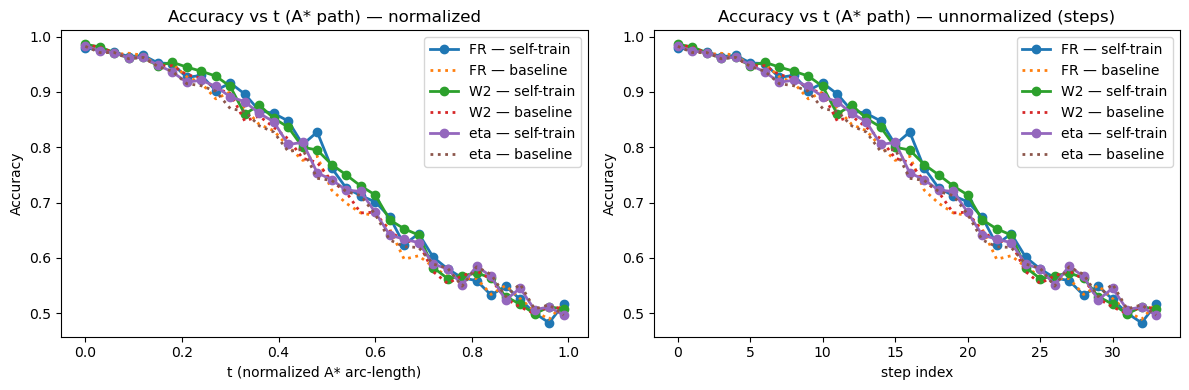

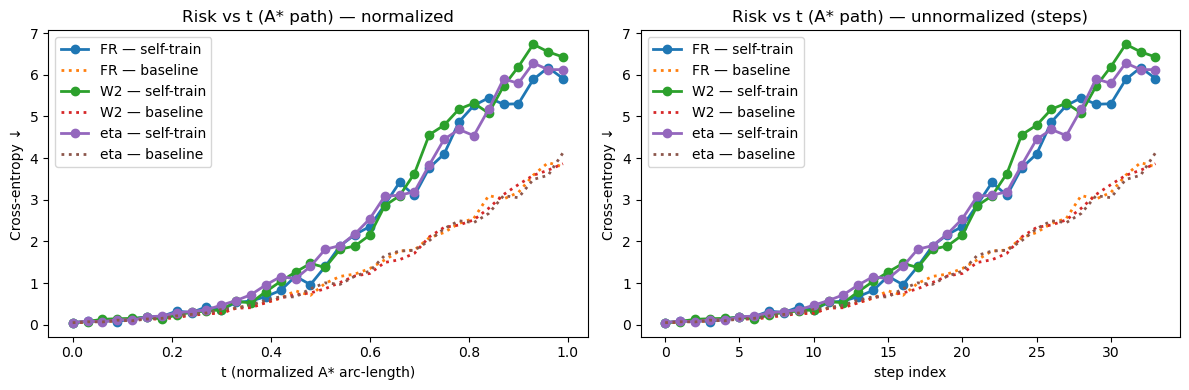

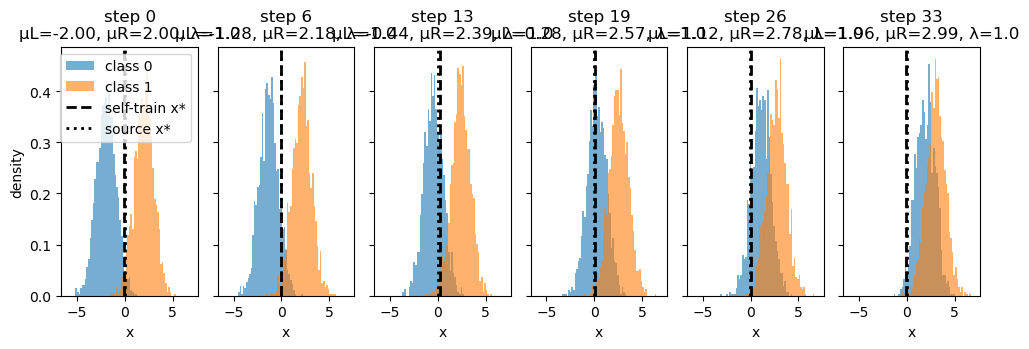

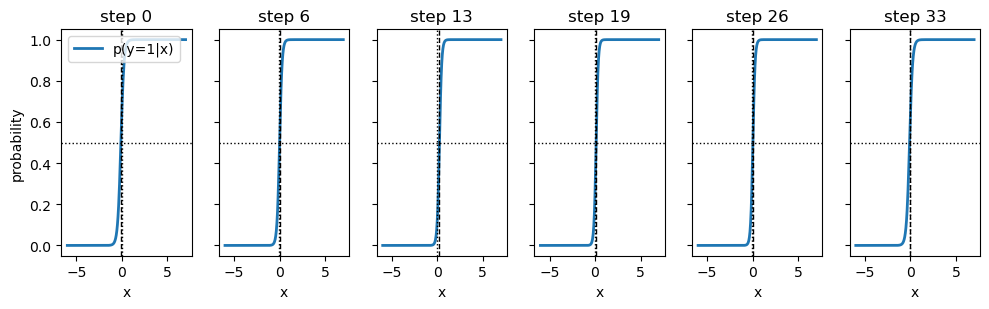

In [59]:
baselines_analytic = {k: baseline_over_analytic_path(k, ts, MU_LEFT0, MU_LEFT1, MU_RIGHT0, MU_RIGHT1, lam0=LAM0, lam1=LAM1, n_per_t=n_per_t, clf_src=clf_src, rng=RNG)
                        for k in results_analytic}

runs_expansion = {
    m: self_train_along_expansion(m, n_per_step=800,
                                    X_source=X_source, Y_source=Y_source, clf_src=clf_src,
                                    mu_left0=MU_LEFT0, mu_left1=MU_LEFT1, mu_right0=MU_RIGHT0, mu_right1=MU_RIGHT1,
                                    lam0=LAM0, lam1=LAM1, grid_n=GRID_N,
                                    neighbor_span=NEIGHBOR_SPAN, stride=6, rng=RNG)
    for m in METRICS
}
plot_expansion_both(runs_expansion, "accs", "Accuracy", "Accuracy vs t (A* path)")
plot_expansion_both(runs_expansion, "ces",  "Cross-entropy ↓", "Risk vs t (A* path)")
plot_evolution_snapshots(runs_expansion["FR"]["snapshots"], clf_src=clf_src, n_vis=3000, bins=80, rng=RNG)


Decision boundary (source-trained): x* = -0.0197
Source accuracy: 0.977
Target accuracy: 0.516


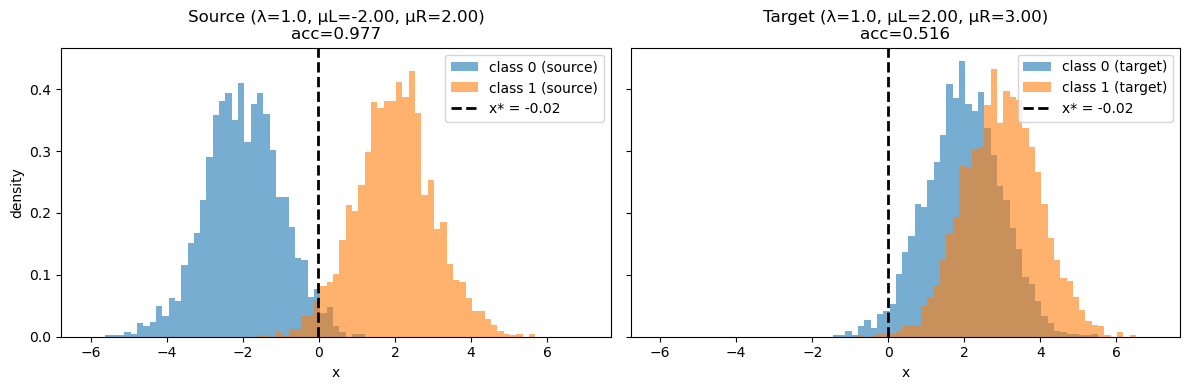

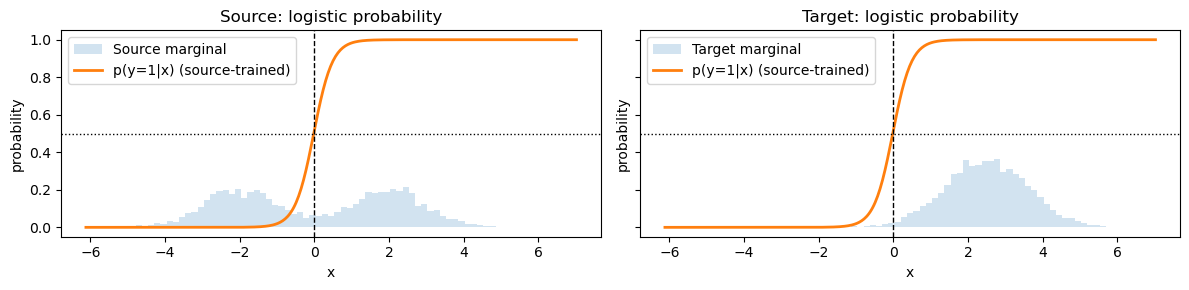

In [60]:
# === Source/Target sampling and bar plots (drop-in) ===

# 1) Sample source (t=0) and target (t=1)
n_vis = 5000
X_src, Y_src = sample_dataset_with_means(
    mu_left=MU_LEFT0,  mu_right=MU_RIGHT0,  lam_val=LAM0, n=n_vis, rng=RNG
)
X_tgt, Y_tgt = sample_dataset_with_means(
    mu_left=MU_LEFT1,  mu_right=MU_RIGHT1,  lam_val=LAM1, n=n_vis, rng=RNG
)

# 2) Train logistic on source and get decision boundary x* = -b / w
clf_src_vis = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000)
clf_src_vis.fit(X_src, Y_src)
w = float(clf_src_vis.coef_.ravel()[0])
b = float(clf_src_vis.intercept_.ravel()[0])
x_star = -b / w

src_acc = clf_src_vis.score(X_src, Y_src)
tgt_acc = clf_src_vis.score(X_tgt, Y_tgt)
print(f"Decision boundary (source-trained): x* = {x_star:.4f}")
print(f"Source accuracy: {src_acc:.3f}")
print(f"Target accuracy: {tgt_acc:.3f}")

# 3) Build common bins across both domains for consistent bars
xmin = float(min(X_src.min(), X_tgt.min())) - 0.5
xmax = float(max(X_src.max(), X_tgt.max())) + 0.5
bins = np.linspace(xmin, xmax, 80)

# 4) Side-by-side class-wise histograms with boundary
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Source panel
ax = axes[0]
ax.hist(X_src[Y_src == 0].ravel(), bins=bins, alpha=0.6, density=True, label="class 0 (source)")
ax.hist(X_src[Y_src == 1].ravel(), bins=bins, alpha=0.6, density=True, label="class 1 (source)")
ax.axvline(x_star, color="k", linestyle="--", linewidth=2, label=f"x* = {x_star:.2f}")
ax.set_title(f"Source (λ={LAM0:.1f}, μL={MU_LEFT0:.2f}, μR={MU_RIGHT0:.2f})\nacc={src_acc:.3f}")
ax.set_xlabel("x"); ax.set_ylabel("density")
ax.legend(loc="upper right")

# --- Target panel
ax = axes[1]
ax.hist(X_tgt[Y_tgt == 0].ravel(), bins=bins, alpha=0.6, density=True, label="class 0 (target)")
ax.hist(X_tgt[Y_tgt == 1].ravel(), bins=bins, alpha=0.6, density=True, label="class 1 (target)")
ax.axvline(x_star, color="k", linestyle="--", linewidth=2, label=f"x* = {x_star:.2f}")
ax.set_title(f"Target (λ={LAM1:.1f}, μL={MU_LEFT1:.2f}, μR={MU_RIGHT1:.2f})\nacc={tgt_acc:.3f}")
ax.set_xlabel("x"); ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

# (Optional) Probability curve p(y=1|x) from the source-trained logistic, overlaid on both domains
xgrid = np.linspace(xmin, xmax, 400).reshape(-1, 1)
p1 = clf_src_vis.predict_proba(xgrid)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
for ax, (X, Y, domain) in zip(axes, [(X_src, Y_src, "Source"), (X_tgt, Y_tgt, "Target")]):
    # light background hist (total)
    ax.hist(X.ravel(), bins=bins, alpha=0.2, density=True, label=f"{domain} marginal")
    ax.plot(xgrid, p1, linewidth=2, label="p(y=1|x) (source-trained)")
    ax.axvline(x_star, color="k", linestyle="--", linewidth=1)
    ax.axhline(0.5, color="k", linestyle=":", linewidth=1)
    ax.set_title(f"{domain}: logistic probability")
    ax.set_xlabel("x"); ax.set_ylabel("probability")
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [ ]:
def plot_geodesic_triptychs_over_ts(
    ts,
    mu0, sigma0, mu1, sigma1,
    n=5000,
    rng=np.random.default_rng(0),
    labeling_function=lambda x: (np.sin(x) > 0).astype(int),
    clf=None,               # LogisticRegression already fit on (X_0, Y_0)
    x_star=None,            # decision boundary = -intercept/coef
    bins=None               # optional fixed bins for all plots
):
    """
    For each t in ts, create a figure with three panels:
      [OT | η (natural) | Fisher–Rao]
    Each panel: class-wise histograms + source decision boundary.
    Also prints the accuracy of the source model on each interpolated set.
    """
    assert clf is not None and x_star is not None, "Pass a trained clf and its x_star."

    # If bins are not provided, compute global bins from a quick pilot sample at the endpoints
    if bins is None:
        pilot = []
        for tt in (0.0, 1.0):
            # OT
            Z_ot = ot_geodesic_samples(rng, tt, mu0, sigma0, mu1, sigma1, n//10)
            pilot.append(Z_ot)
            # η
            eta_src = to_natural(mu0, sigma0**2)
            eta_tgt = to_natural(mu1, sigma1**2)
            Z_eta = eta_geodesic_samples(rng, tt, eta_src, eta_tgt, n//10)
            pilot.append(Z_eta)
            # FR
            Z_fr = fisher_rao_geodesic_samples(rng, tt, mu0, sigma0, mu1, sigma1, n//10)
            pilot.append(Z_fr)
        vmin = min(p.min() for p in pilot) - 0.5
        vmax = max(p.max() for p in pilot) + 0.5
        bins = np.linspace(vmin, vmax, 80)

    for t in ts:
        # --- Sample from each geodesic at this t
        Z_ot  = ot_geodesic_samples(rng, t, mu0, sigma0, mu1, sigma1, n)
        eta_src = to_natural(mu0, sigma0**2)
        eta_tgt = to_natural(mu1, sigma1**2)
        Z_eta = eta_geodesic_samples(rng, t, eta_src, eta_tgt, n)
        Z_fr  = fisher_rao_geodesic_samples(rng, t, mu0, sigma0, mu1, sigma1, n)

        # Column vectors for the classifier + labels via your labeling function
        X_ot  = Z_ot.reshape(-1, 1)
        X_eta = Z_eta.reshape(-1, 1)
        X_fr  = Z_fr.reshape(-1, 1)

        Y_ot  = labeling_function(X_ot).ravel()
        Y_eta = labeling_function(X_eta).ravel()
        Y_fr  = labeling_function(X_fr).ravel()

        # Source model accuracy on each interpolated set
        acc_ot  = clf.score(X_ot,  Y_ot)
        acc_eta = clf.score(X_eta, Y_eta)
        acc_fr  = clf.score(X_fr,  Y_fr)

        # --- Figure with 3 panels
        fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
        panels = [
            ("OT (W2)", X_ot, Y_ot, acc_ot),
            ("η (natural)", X_eta, Y_eta, acc_eta),
            ("Fisher–Rao", X_fr, Y_fr, acc_fr),
        ]

        for ax, (title, X, Y, acc) in zip(axes, panels):
            ax.hist(X[Y==0].ravel(), bins=bins, alpha=0.6, density=True, label="class 0")
            ax.hist(X[Y==1].ravel(), bins=bins, alpha=0.6, density=True, label="class 1")
            ax.axvline(x_star, linestyle="--", linewidth=2, color="k", label=f"x*={x_star:.2f}")
            ax.set_title(f"{title} @ t={t:.2f}  |  acc={acc:.3f}")
            ax.set_xlabel("x")

        axes[0].set_ylabel("density")
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.08))
        fig.tight_layout()
        plt.show()


In [ ]:
# endpoints and source model from your snippet:
rng = np.random.default_rng(42)
# mu0, sigma0 = 0.0, 1.0
# mu1, sigma1 = 10.0, 3.0
n = 5000

# labels via your function, source training data & model
labeling_function = lambda x: (np.sin(x) > 0).astype(int)
X_0 = rng.normal(mu0, sigma0, size=n).reshape(-1, 1)
Y_0 = labeling_function(X_0)
clf = LogisticRegression(penalty='l2').fit(X_0, Y_0)
w = clf.coef_.ravel()[0]; b = clf.intercept_.ravel()[0]
x_star = -b / w

# pick a few t's and plot
ts = [0.0, 0.25, 0.5, 0.75, 1.0]
plot_geodesic_triptychs_over_ts(ts, mu0, sigma0, mu1, sigma1,
                                n=4000, rng=rng,
                                labeling_function=labeling_function,
                                clf=clf, x_star=x_star)
